In [78]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" #HEADER_LEN,X_DIM,Y_DIM,X_left_boundry,X_right_boundry,Y_left_boundry,Y_right_boundry
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" # frame rate, shutter delay, and interseted position 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers

In [79]:
folder = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023"

In [80]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)

[4, 28, 2, 2, 18, 2, 12, 1, 8, 5, 41]


In [84]:
Si_melting_W = {
    '103': 41.5,
    '13': 35.4,
    '155': 43.7,
    '190': 45.5,
    #'20': 35.5,
    '234': 47,
    '30': 36.3,
    '352': 52.2,
    '45': 37.1,
    '68': 39.2,
    #'9': 35.3 
    
}

In [85]:
gold_melting_W = {
    '103': 37,
    '13': 30.2,
    '155': 38.9,
    '190': 40.3,
    #'20': 30.8,
    '234': 41.9,
    '30': 31.9,
    '352': 46.2,
    '45': 33.5,
    '68': 35.2,
    #'9': 29.9
    
}

In [86]:
v_list = ['103','13', '155', '190','234','30','352','45', '68']
Dict_1 = dict((k, fivemm_files[k][5:]) for k in v_list) # not included 0W files
back_intensity_list_1 = []
for key in fivemm_files:
    if key in v_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_1.append(back_intensity_list[index])
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_1[i], gaus, gaus)
        con.append(val)
    dRoverR_1.append(con)

In [87]:
power_used = {
        '103':[27+2*p for p in range(0,len(dRoverR_1[v_list.index('103')]),1)], 
        '13':[21+2*p for p in range(0,len(dRoverR_1[v_list.index('13')]),1)], 
        #'20':[23+2*p for p in range(0,len(dRoverR_1[v_list.index('20')]),1)],
        '155':[27+2*p for p in range(0,len(dRoverR_1[v_list.index('155')]),1)],
        '190':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('190')]),1)], 
        '234':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('234')]),1)],
        '30':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('30')]),1)], 
        '352':[31+2*p for p in range(0,len(dRoverR_1[v_list.index('352')]),1)], 
        '45':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('45')]),1)], 
        '68':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('68')]),1)]
        #'9':[21+2*p for p in range(0,len(dRoverR_1[v_list.index('9')]),1)]
          
        }


### Plot all frames dR/R

In [90]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
                
        #convert the frame number to position
        #x = [(frame-2.7)*int(key)/92.59 for frame in range(1,len(temp_list)+1)] 
        
        x = [frame for frame in range(0,len(dR_list))] 
        
        
        plt.plot(x, dR_list, marker="o")
        
        #limit temperature to 1500C
        #plt.ylim(0,1500)
        
        #limit position to 1-10mm
        #plt.xlim(0,5)

    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_vs_frame/{}mmpersec.png".format(key), format="PNG")
    plt.close()

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_000.raw


 39%|███▊      | 151/390 [00:00<00:01, 158.22it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 43%|████▎     | 167/390 [00:08<00:15, 14.24it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_023.raw


 45%|████▍     | 174/390 [00:15<00:28,  7.51it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_027.raw


 46%|████▌     | 178/390 [00:17<00:32,  6.44it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_27W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_000.raw


 46%|████▋     | 181/390 [00:00<00:01, 183.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 51%|█████▏    | 200/390 [00:11<00:14, 12.73it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_020.raw


 52%|█████▏    | 201/390 [00:13<00:17, 11.02it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 54%|█████▎    | 209/390 [00:18<00:28,  6.46it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_29W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_000.raw


 54%|█████▍    | 211/390 [00:00<00:00, 263.66it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 61%|██████    | 238/390 [00:14<00:12, 11.95it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_028.raw


 61%|██████▏   | 239/390 [00:15<00:13, 11.36it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_31W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_000.raw


 62%|██████▏   | 241/390 [00:01<00:00, 220.39it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 68%|██████▊   | 264/390 [00:12<00:07, 16.07it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_024.raw


 68%|██████▊   | 265/390 [00:13<00:08, 14.76it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_33W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_000.raw


 69%|██████▉   | 271/390 [00:00<00:00, 453.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 69%|██████▉   | 271/390 [00:12<00:00, 453.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_025.raw


 76%|███████▌  | 296/390 [00:13<00:05, 16.38it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_026.raw


 76%|███████▌  | 297/390 [00:13<00:06, 15.41it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_35W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_000.raw


 77%|███████▋  | 301/390 [00:00<00:00, 431.34it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_37W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_000.raw


 85%|████████▍ | 331/390 [00:00<00:00, 367.27it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 85%|████████▍ | 331/390 [00:11<00:00, 367.27it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_025.raw


 91%|█████████▏| 356/390 [00:12<00:01, 21.33it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_026.raw


 92%|█████████▏| 357/390 [00:12<00:01, 20.30it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_39W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_000.raw


 93%|█████████▎| 361/390 [00:00<00:00, 425.57it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/103mm_per_sec/-18mm_41W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_000.raw


 36%|███▌      | 201/560 [00:05<00:09, 36.68it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_004.raw


 37%|███▋      | 205/560 [00:11<00:25, 14.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_006.raw


 37%|███▋      | 207/560 [00:14<00:32, 10.79it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_007.raw


 37%|███▋      | 209/560 [00:15<00:36,  9.57it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_009.raw


 38%|███▊      | 210/560 [00:15<00:39,  8.83it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_010.raw


 38%|███▊      | 212/560 [00:16<00:41,  8.45it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_012.raw


 38%|███▊      | 214/560 [00:16<00:50,  6.84it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_015.raw


 39%|███▉      | 218/560 [00:17<00:42,  8.11it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_018.raw


 39%|███▉      | 220/560 [00:21<03:22,  1.68it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_020.raw


 40%|███▉      | 222/560 [00:21<02:28,  2.27it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_022.raw


 40%|███▉      | 223/560 [00:22<02:03,  2.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_023.raw


 40%|████      | 225/560 [00:22<01:38,  3.41it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_025.raw


 41%|████      | 227/560 [00:22<01:09,  4.79it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_027.raw


 41%|████      | 228/560 [00:22<01:01,  5.42it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_028.raw


 41%|████      | 229/560 [00:23<01:17,  4.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_029.raw


 41%|████      | 230/560 [00:23<01:47,  3.06it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_030.raw


 41%|████▏     | 232/560 [00:24<01:36,  3.40it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_033.raw


 42%|████▏     | 234/560 [00:24<01:14,  4.40it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_035.raw


 42%|████▏     | 237/560 [00:24<00:55,  5.82it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_037.raw


100%|██████████| 560/560 [00:25<00:00, 22.01it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_21W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_000.raw


 43%|████▎     | 241/560 [00:05<00:06, 46.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_005.raw


 44%|████▍     | 246/560 [00:10<00:16, 18.80it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_007.raw


 44%|████▍     | 248/560 [00:12<00:19, 15.89it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_008.raw


 45%|████▍     | 250/560 [00:12<00:20, 14.88it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_010.raw


 45%|████▌     | 253/560 [00:12<00:21, 14.58it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_013.raw


 46%|████▌     | 256/560 [00:13<00:22, 13.44it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_016.raw


 46%|████▌     | 257/560 [00:13<00:24, 12.29it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_018.raw


 47%|████▋     | 261/560 [00:16<01:04,  4.64it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_021.raw


 47%|████▋     | 263/560 [00:16<00:56,  5.22it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_024.raw


 48%|████▊     | 267/560 [00:16<00:42,  6.89it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_027.raw


 48%|████▊     | 269/560 [00:16<00:37,  7.83it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_030.raw


 49%|████▉     | 273/560 [00:17<00:30,  9.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_033.raw


 49%|████▉     | 275/560 [00:17<00:28, 10.11it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_035.raw


 49%|████▉     | 277/560 [00:17<00:30,  9.16it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_037.raw


100%|██████████| 560/560 [00:17<00:00, 31.34it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_23W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_000.raw


 50%|█████     | 281/560 [00:05<00:05, 48.23it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_005.raw


 51%|█████     | 286/560 [00:11<00:13, 21.05it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_007.raw


 52%|█████▏    | 289/560 [00:14<00:18, 14.64it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_009.raw


 52%|█████▏    | 291/560 [00:14<00:18, 14.24it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_012.raw


 53%|█████▎    | 295/560 [00:15<00:18, 14.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_015.raw


 53%|█████▎    | 297/560 [00:15<00:18, 13.86it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_017.raw


 53%|█████▎    | 299/560 [00:15<00:18, 13.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_020.raw


 54%|█████▍    | 303/560 [00:15<00:18, 13.78it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_023.raw


 54%|█████▍    | 305/560 [00:15<00:18, 13.77it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_026.raw


 55%|█████▌    | 309/560 [00:16<00:18, 13.51it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_029.raw


 56%|█████▌    | 311/560 [00:16<00:19, 13.02it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_031.raw


 56%|█████▌    | 313/560 [00:16<00:20, 11.85it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_034.raw


 57%|█████▋    | 317/560 [00:16<00:19, 12.48it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_035.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_037.raw


100%|██████████| 560/560 [00:17<00:00, 32.62it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_25W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_000.raw


 57%|█████▋    | 321/560 [00:04<00:03, 67.67it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_007.raw


 59%|█████▊    | 328/560 [00:12<00:10, 21.38it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_010.raw


 59%|█████▉    | 331/560 [00:12<00:10, 21.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_013.raw


 60%|█████▉    | 334/560 [00:12<00:10, 20.86it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_015.raw


 60%|██████    | 338/560 [00:13<00:11, 19.79it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_018.raw


 61%|██████    | 340/560 [00:14<00:18, 12.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_021.raw


 61%|██████▏   | 344/560 [00:14<00:17, 12.19it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_024.raw


 62%|██████▏   | 346/560 [00:15<00:17, 12.26it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_027.raw


 62%|██████▏   | 348/560 [00:15<00:17, 12.33it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_029.raw


 63%|██████▎   | 352/560 [00:15<00:17, 11.65it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_032.raw


 63%|██████▎   | 354/560 [00:15<00:17, 11.87it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_035.raw


 64%|██████▍   | 358/560 [00:16<00:16, 12.49it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_038.raw


100%|██████████| 560/560 [00:16<00:00, 34.40it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_27W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_000.raw


 64%|██████▍   | 361/560 [00:05<00:02, 71.14it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_007.raw


 66%|██████▌   | 369/560 [00:12<00:08, 23.39it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_010.raw


 66%|██████▋   | 372/560 [00:12<00:08, 23.12it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_013.raw


 67%|██████▋   | 375/560 [00:13<00:08, 22.76it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_016.raw


 67%|██████▋   | 377/560 [00:13<00:08, 22.47it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_018.raw


 68%|██████▊   | 381/560 [00:13<00:08, 20.99it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_021.raw


 68%|██████▊   | 383/560 [00:13<00:08, 20.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_024.raw


 69%|██████▉   | 387/560 [00:14<00:09, 18.99it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_027.raw


 69%|██████▉   | 389/560 [00:14<00:09, 18.12it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_030.raw


 70%|███████   | 393/560 [00:14<00:10, 16.48it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_033.raw


 71%|███████   | 395/560 [00:14<00:10, 15.78it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_035.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_036.raw


 71%|███████▏  | 399/560 [00:14<00:10, 14.85it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_29W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_000.raw


 72%|███████▏  | 401/560 [00:03<00:01, 133.44it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_p

 74%|███████▍  | 415/560 [00:10<00:04, 29.24it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_020.raw


 75%|███████▌  | 421/560 [00:11<00:04, 28.39it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_023.raw


 76%|███████▌  | 425/560 [00:11<00:04, 27.57it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_026.raw


 76%|███████▋  | 428/560 [00:11<00:04, 26.81it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_029.raw


 77%|███████▋  | 431/560 [00:12<00:04, 25.93it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_032.raw


 78%|███████▊  | 435/560 [00:12<00:05, 24.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_035.raw


 78%|███████▊  | 437/560 [00:12<00:05, 23.03it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_038.raw


100%|██████████| 560/560 [00:12<00:00, 43.73it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_31W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_000.raw


 79%|███████▉  | 441/560 [00:04<00:01, 104.13it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_p

 81%|████████  | 452/560 [00:12<00:03, 27.69it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_016.raw


 82%|████████▏ | 457/560 [00:13<00:03, 26.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_019.raw


 82%|████████▏ | 460/560 [00:13<00:03, 25.94it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_022.raw


 83%|████████▎ | 465/560 [00:14<00:03, 24.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_025.raw


 83%|████████▎ | 467/560 [00:14<00:03, 23.42it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_028.raw


 84%|████████▍ | 471/560 [00:14<00:04, 21.54it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_031.raw


 84%|████████▍ | 473/560 [00:14<00:04, 20.52it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_034.raw


 85%|████████▌ | 477/560 [00:14<00:04, 18.51it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_035.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_037.raw


100%|██████████| 560/560 [00:15<00:00, 36.81it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_33W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_000.raw


 86%|████████▌ | 481/560 [00:02<00:00, 189.89it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_p

 89%|████████▉ | 500/560 [00:12<00:01, 30.53it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_024.raw


 91%|█████████ | 508/560 [00:12<00:01, 29.50it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_p

 92%|█████████▏| 513/560 [00:13<00:01, 28.66it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_035.raw


 92%|█████████▏| 517/560 [00:13<00:01, 27.59it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_038.raw


100%|██████████| 560/560 [00:13<00:00, 40.19it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_35W_039.raw


  0%|          | 0/560 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_000.raw


 93%|█████████▎| 521/560 [00:04<00:00, 119.07it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_p

 95%|█████████▌| 533/560 [00:14<00:00, 28.78it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_013.raw


 96%|█████████▌| 535/560 [00:14<00:00, 28.47it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_019.raw


 97%|█████████▋| 541/560 [00:15<00:00, 25.91it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_024.raw


 97%|█████████▋| 545/560 [00:18<00:00, 16.60it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_027.raw


 98%|█████████▊| 548/560 [00:27<00:01,  6.91it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_029.raw


 98%|█████████▊| 550/560 [00:31<00:02,  4.84it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_030.raw


 98%|█████████▊| 551/560 [00:34<00:02,  3.84it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_031.raw


 99%|█████████▊| 552/560 [00:37<00:02,  3.22it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_032.raw


 99%|█████████▉| 553/560 [00:39<00:02,  2.67it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_033.raw


 99%|█████████▉| 554/560 [00:40<00:02,  2.46it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_034.raw


 99%|█████████▉| 555/560 [00:41<00:02,  2.26it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_035.raw


 99%|█████████▉| 556/560 [00:42<00:02,  1.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_036.raw


 99%|█████████▉| 557/560 [00:43<00:01,  1.62it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_037.raw


100%|█████████▉| 558/560 [00:47<00:02,  1.07s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_038.raw


100%|█████████▉| 559/560 [00:49<00:01,  1.15s/it]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/13mm_per_sec/-8mm_37W_039.raw


  0%|          | 0/480 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_000.raw


 31%|███▏      | 151/480 [00:00<00:01, 263.75it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 37%|███▋      | 178/480 [00:13<00:29, 10.22it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_028.raw


 37%|███▋      | 179/480 [00:13<00:30,  9.81it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_27W_029.raw


 38%|███▊      | 181/480 [00:00<00:00, 1786.23it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 42%|████▎     | 204/480 [00:11<00:21, 13.03it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_024.raw


 43%|████▎     | 205/480 [00:12<00:23, 11.90it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_29W_029.raw


  0%|          | 0/480 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_000.raw


 44%|████▍     | 211/480 [00:00<00:00, 605.22it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 50%|█████     | 242/480 [00:00<00:00, 1411.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 50%|█████     | 242/480 [00:10<00:00, 1411.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_022.raw


 55%|█████▍    | 263/480 [00:11<00:13, 16.25it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_023.raw


 55%|█████▌    | 264/480 [00:12<00:14, 15.13it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_33W_029.raw


  0%|          | 0/480 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_001.raw


 57%|█████▋    | 272/480 [00:00<00:00, 371.49it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_35W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/480 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_001.raw


 63%|██████▎   | 302/480 [00:00<00:00, 1127.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 68%|██████▊   | 327/480 [00:14<00:09, 16.49it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_027.raw


 68%|██████▊   | 328/480 [00:14<00:09, 16.04it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_37W_029.raw


 69%|██████▉   | 331/480 [00:00<00:00, 2493.31it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_39W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 75%|███████▌  | 361/480 [00:00<00:00, 3221.92it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_41W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 82%|████████▏ | 392/480 [00:00<00:00, 2628.64it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_43W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 88%|████████▊ | 421/480 [00:00<00:00, 3102.84it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_45W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 94%|█████████▍| 451/480 [00:00<00:00, 2324.43it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/155mm_per_sec/20mm_47W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 34%|███▎      | 151/450 [00:00<00:00, 1456.98it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 36%|███▌      | 162/450 [00:12<00:31,  9.10it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_012.raw


 36%|███▌      | 163/450 [00:14<00:36,  7.83it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_29W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/450 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_000.raw


 40%|████      | 181/450 [00:00<00:00, 835.73it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 44%|████▍     | 200/450 [00:20<00:34,  7.22it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_020.raw


 45%|████▍     | 201/450 [00:21<00:37,  6.70it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_31W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 47%|████▋     | 211/450 [00:00<00:00, 1554.67it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 47%|████▋     | 211/450 [00:19<00:00, 1554.67it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_018.raw


 51%|█████     | 229/450 [00:20<00:27,  8.01it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_019.raw


 51%|█████     | 230/450 [00:21<00:29,  7.56it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_33W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/450 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_001.raw


 54%|█████▍    | 242/450 [00:00<00:00, 754.08it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 58%|█████▊    | 260/450 [00:19<00:19,  9.91it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_020.raw


 58%|█████▊    | 261/450 [00:19<00:19,  9.51it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_35W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 60%|██████    | 271/450 [00:00<00:00, 2029.92it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 65%|██████▌   | 293/450 [00:20<00:14, 10.54it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_023.raw


 65%|██████▌   | 294/450 [00:20<00:15, 10.02it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_37W_029.raw


 67%|██████▋   | 302/450 [00:00<00:00, 1589.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 67%|██████▋   | 302/450 [00:12<00:00, 1589.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_014.raw


 70%|███████   | 315/450 [00:13<00:08, 16.70it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_015.raw


 70%|███████   | 316/450 [00:15<00:09, 14.42it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_39W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 74%|███████▎  | 331/450 [00:00<00:00, 1959.73it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 76%|███████▋  | 344/450 [00:15<00:06, 15.39it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_014.raw


 77%|███████▋  | 345/450 [00:17<00:07, 13.67it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_41W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 80%|████████  | 362/450 [00:00<00:00, 2199.95it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 83%|████████▎ | 374/450 [00:12<00:03, 21.13it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_014.raw


 83%|████████▎ | 375/450 [00:13<00:04, 18.67it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_43W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/450 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_000.raw


 87%|████████▋ | 391/450 [00:00<00:00, 1827.07it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 87%|████████▋ | 391/450 [00:13<00:00, 1827.07it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_013.raw


 90%|████████▉ | 404/450 [00:14<00:02, 19.53it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_014.raw


 90%|█████████ | 405/450 [00:15<00:02, 18.04it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_45W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 94%|█████████▍| 422/450 [00:00<00:00, 2508.62it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 97%|█████████▋| 436/450 [00:15<00:00, 20.06it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_016.raw


 97%|█████████▋| 437/450 [00:16<00:00, 18.72it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/190mm_per_sec/-22mm_47W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 42%|████▏     | 151/360 [00:00<00:00, 1345.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:13<00:00, 26.16it/s]  


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_23W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_000.raw


 50%|█████     | 181/360 [00:00<00:00, 379.92it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:15<00:00, 23.67it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_25W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_000.raw


 59%|█████▊    | 211/360 [00:00<00:00, 731.33it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:13<00:00, 26.09it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_27W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_000.raw


 67%|██████▋   | 241/360 [00:00<00:00, 375.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_004.raw


 68%|██████▊   | 245/360 [00:11<00:07, 15.76it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_005.raw


 68%|██████▊   | 246/360 [00:11<00:07, 15.12it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 73%|███████▎  | 262/360 [00:12<00:06, 14.76it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_29W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_000.raw


 75%|███████▌  | 271/360 [00:00<00:00, 691.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_000.raw


 84%|████████▎ | 301/360 [00:00<00:00, 572.43it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:08<00:00, 44.91it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_33W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_000.raw


 92%|█████████▏| 331/360 [00:01<00:00, 283.79it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/20mm_per_sec/-10mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 31%|███▏      | 151/480 [00:00<00:00, 1441.61it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 35%|███▍      | 166/480 [00:15<00:39,  7.95it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_016.raw


 35%|███▍      | 167/480 [00:16<00:44,  7.06it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_29W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 38%|███▊      | 181/480 [00:00<00:00, 1747.88it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 40%|████      | 193/480 [00:11<00:23, 12.30it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_013.raw


 40%|████      | 194/480 [00:13<00:29,  9.71it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 43%|████▎     | 206/480 [00:30<01:22,  3.33it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_026.raw


 43%|████▎     | 207/480 [00:32<01:29,  3.05it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_31W_029.raw


 44%|████▍     | 211/480 [00:00<00:00, 1537.93it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 47%|████▋     | 225/480 [00:14<00:22, 11.39it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_015.raw


 47%|████▋     | 226/480 [00:16<00:27,  9.34it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 50%|████▉     | 239/480 [00:34<01:09,  3.45it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_33W_029.raw


  0%|          | 0/480 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_000.raw


 50%|█████     | 241/480 [00:00<00:00, 629.46it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 54%|█████▎    | 257/480 [00:19<00:23,  9.57it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_017.raw


 54%|█████▍    | 258/480 [00:20<00:24,  9.04it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_35W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 56%|█████▋    | 271/480 [00:00<00:00, 2078.56it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 60%|██████    | 289/480 [00:19<00:17, 10.75it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_019.raw


 60%|██████    | 290/480 [00:20<00:19,  9.93it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_37W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 63%|██████▎   | 302/480 [00:00<00:00, 2111.19it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 63%|██████▎   | 302/480 [00:16<00:00, 2111.19it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_015.raw


 66%|██████▌   | 316/480 [00:18<00:13, 12.29it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_016.raw


 66%|██████▌   | 317/480 [00:21<00:16,  9.96it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 68%|██████▊   | 327/480 [00:36<00:32,  4.64it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_027.raw


 68%|██████▊   | 328/480 [00:38<00:35,  4.27it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_39W_029.raw


 69%|██████▉   | 332/480 [00:00<00:00, 2162.08it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 72%|███████▏  | 345/480 [00:14<00:07, 17.13it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_015.raw


 72%|███████▏  | 346/480 [00:15<00:08, 15.81it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_41W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 75%|███████▌  | 362/480 [00:00<00:00, 2514.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 79%|███████▉  | 380/480 [00:19<00:07, 13.64it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_020.raw


 79%|███████▉  | 381/480 [00:20<00:07, 13.26it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_43W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 81%|████████▏ | 391/480 [00:00<00:00, 3434.74it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 84%|████████▍ | 404/480 [00:16<00:04, 17.60it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_014.raw


 84%|████████▍ | 405/480 [00:17<00:04, 15.75it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 87%|████████▋ | 419/480 [00:36<00:10,  5.60it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_45W_029.raw


 88%|████████▊ | 422/480 [00:00<00:00, 2908.05it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 92%|█████████▏| 441/480 [00:20<00:02, 15.71it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_021.raw


 92%|█████████▏| 442/480 [00:20<00:02, 15.00it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_47W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 94%|█████████▍| 452/480 [00:00<00:00, 2734.11it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 98%|█████████▊| 469/480 [00:17<00:00, 18.66it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_019.raw


 98%|█████████▊| 470/480 [00:18<00:00, 17.51it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/234mm_per_sec/-24mm_49W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 42%|████▏     | 151/360 [00:00<00:00, 1495.71it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:04<00:00, 88.96it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_25W_029.raw



  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_001.raw


 51%|█████     | 182/360 [00:00<00:00, 376.47it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_27W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 59%|█████▊    | 211/360 [00:00<00:00, 2044.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_000.raw


 67%|██████▋   | 241/360 [00:00<00:00, 1182.44it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:03<00:00, 93.56it/s]  


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_31W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_001.raw


 76%|███████▌  | 272/360 [00:00<00:00, 1512.53it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_33W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 84%|████████▍ | 302/360 [00:00<00:00, 1850.95it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_001.raw


 92%|█████████▏| 332/360 [00:00<00:00, 960.36it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_37W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_000.raw


 28%|██▊       | 151/540 [00:00<00:00, 455.18it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 31%|███       | 165/540 [00:17<00:55,  6.77it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_015.raw


 31%|███       | 166/540 [00:21<01:10,  5.29it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_022.raw


 31%|███       | 166/540 [00:36<01:10,  5.29it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_023.raw


 32%|███▏      | 174/540 [00:37<02:27,  2.47it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_024.raw


 32%|███▏      | 175/540 [00:38<02:34,  2.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_31W_029.raw


 34%|███▎      | 181/540 [00:00<00:00, 1059.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 34%|███▎      | 181/540 [00:17<00:00, 1059.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_017.raw


 37%|███▋      | 198/540 [00:19<00:45,  7.52it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_018.raw


 37%|███▋      | 199/540 [00:21<00:52,  6.52it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 39%|███▊      | 209/540 [00:38<01:54,  2.90it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_33W_029.raw


 39%|███▉      | 212/540 [00:00<00:00, 1398.80it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 42%|████▏     | 226/540 [00:17<00:34,  9.13it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_016.raw


 42%|████▏     | 227/540 [00:20<00:40,  7.78it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 44%|████▍     | 237/540 [00:38<01:37,  3.10it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_027.raw


 44%|████▍     | 238/540 [00:41<01:47,  2.80it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_35W_029.raw


 45%|████▍     | 242/540 [00:00<00:00, 1715.62it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 47%|████▋     | 253/540 [00:13<00:21, 13.05it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_013.raw


 47%|████▋     | 254/540 [00:16<00:28, 10.10it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 49%|████▉     | 264/540 [00:34<01:13,  3.75it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_024.raw


 49%|████▉     | 265/540 [00:35<01:17,  3.53it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_37W_029.raw


  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_000.raw


 50%|█████     | 271/540 [00:00<00:00, 1069.12it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 53%|█████▎    | 288/540 [00:20<00:25, 10.01it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_018.raw


 54%|█████▎    | 289/540 [00:21<00:27,  9.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_39W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_000.raw


 56%|█████▌    | 301/540 [00:00<00:00, 1087.40it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 59%|█████▊    | 317/540 [00:21<00:20, 10.74it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_017.raw


 59%|█████▉    | 318/540 [00:23<00:23,  9.50it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_41W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_000.raw


 61%|██████▏   | 331/540 [00:00<00:00, 752.50it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 64%|██████▍   | 346/540 [00:22<00:17, 10.94it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_016.raw


 64%|██████▍   | 347/540 [00:23<00:18, 10.42it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 66%|██████▋   | 359/540 [00:41<00:40,  4.46it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_43W_029.raw


  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_000.raw


 67%|██████▋   | 361/540 [00:00<00:00, 1358.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 70%|██████▉   | 376/540 [00:19<00:11, 14.09it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_016.raw


 70%|██████▉   | 377/540 [00:21<00:13, 12.31it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 70%|██████▉   | 377/540 [00:37<00:13, 12.31it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_028.raw


 72%|███████▏  | 389/540 [00:39<00:30,  5.00it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_45W_029.raw


 72%|███████▏  | 391/540 [00:00<00:00, 2409.39it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_000.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 75%|███████▌  | 406/540 [00:16<00:07, 17.40it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_016.raw


 75%|███████▌  | 407/540 [00:19<00:09, 14.05it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_023.raw


 77%|███████▋  | 414/540 [00:35<00:22,  5.61it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_024.raw


 77%|███████▋  | 415/540 [00:36<00:22,  5.51it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_47W_029.raw


  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_000.raw


 78%|███████▊  | 421/540 [00:00<00:00, 573.55it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 80%|████████  | 434/540 [00:13<00:04, 22.77it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_014.raw


 81%|████████  | 435/540 [00:15<00:05, 18.72it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 82%|████████▏ | 444/540 [00:32<00:14,  6.50it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_024.raw


 82%|████████▏ | 445/540 [00:33<00:15,  6.13it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_49W_029.raw


  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_000.raw


 84%|████████▎ | 451/540 [00:00<00:00, 1119.16it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 84%|████████▎ | 451/540 [00:19<00:00, 1119.16it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_016.raw


 86%|████████▋ | 467/540 [00:21<00:04, 15.35it/s]  

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_017.raw


 87%|████████▋ | 468/540 [00:24<00:05, 13.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 89%|████████▊ | 479/540 [00:40<00:09,  6.14it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_51W_029.raw


  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_000.raw


 89%|████████▉ | 481/540 [00:00<00:00, 527.28it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 92%|█████████▏| 497/540 [00:20<00:02, 17.22it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_017.raw


 92%|█████████▏| 498/540 [00:22<00:02, 15.63it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 94%|█████████▍| 509/540 [00:39<00:04,  6.62it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_53W_029.raw


  0%|          | 0/540 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_000.raw


 95%|█████████▍| 511/540 [00:01<00:00, 366.35it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

 95%|█████████▍| 511/540 [00:18<00:00, 366.35it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_016.raw


 98%|█████████▊| 527/540 [00:19<00:00, 19.54it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_017.raw


 98%|█████████▊| 528/540 [00:22<00:00, 16.04it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/01

100%|█████████▉| 539/540 [00:39<00:00,  6.83it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/352mm_per_sec/-26mm_55W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_000.raw


 42%|████▏     | 151/360 [00:00<00:00, 320.41it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:06<00:00, 59.41it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_25W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_000.raw


 50%|█████     | 181/360 [00:00<00:00, 226.02it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 57%|█████▋    | 204/360 [00:04<00:03, 39.42it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_028.raw


100%|██████████| 360/360 [00:06<00:00, 58.18it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_27W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_000.raw


 59%|█████▊    | 211/360 [00:01<00:00, 196.42it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 64%|██████▍   | 231/360 [00:05<00:04, 29.64it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:07<00:00, 46.82it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_29W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_000.raw


 67%|██████▋   | 241/360 [00:00<00:00, 284.45it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 360/360 [00:09<00:00, 38.05it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_31W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_000.raw


 75%|███████▌  | 271/360 [00:01<00:00, 249.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 82%|████████▏ | 296/360 [00:05<00:01, 44.25it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_028.raw


100%|██████████| 360/360 [00:06<00:00, 58.96it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_33W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_000.raw


 84%|████████▎ | 301/360 [00:01<00:00, 250.63it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 91%|█████████ | 327/360 [00:07<00:01, 32.06it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_028.raw


100%|██████████| 360/360 [00:08<00:00, 43.22it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_35W_029.raw


  0%|          | 0/360 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_000.raw


 92%|█████████▏| 331/360 [00:00<00:00, 2035.89it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/45mm_per_sec/-14mm_37W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_000.raw


 39%|███▊      | 151/390 [00:00<00:00, 324.65it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_25W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_000.raw


 46%|████▋     | 181/390 [00:01<00:02, 99.58it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 49%|████▉     | 191/390 [00:03<00:04, 44.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_014.raw


 50%|█████     | 196/390 [00:05<00:07, 25.59it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_018.raw


 51%|█████     | 199/390 [00:07<00:12, 14.82it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_020.raw


 52%|█████▏    | 201/390 [00:09<00:19,  9.65it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_022.raw


 52%|█████▏    | 203/390 [00:10<00:23,  7.80it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_023.raw


 52%|█████▏    | 204/390 [00:11<00:26,  7.07it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_025.raw


 53%|█████▎    | 206/390 [00:11<00:28,  6.43it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_027.raw


 53%|█████▎    | 208/390 [00:12<00:29,  6.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_028.raw


 54%|█████▎    | 209/390 [00:12<00:30,  5.87it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_27W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_000.raw


 54%|█████▍    | 211/390 [00:01<00:00, 196.97it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

 59%|█████▉    | 231/390 [00:04<00:03, 40.59it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_29W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_000.raw


 62%|██████▏   | 241/390 [00:00<00:00, 311.82it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_31W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_000.raw


 69%|██████▉   | 271/390 [00:00<00:00, 372.81it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_000.raw


 77%|███████▋  | 301/390 [00:00<00:00, 447.64it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_35W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_000.raw


 85%|████████▍ | 331/390 [00:00<00:00, 871.80it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 390/390 [00:06<00:00, 60.56it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_37W_029.raw


  0%|          | 0/390 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_000.raw


 93%|█████████▎| 361/390 [00:00<00:00, 378.66it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023

100%|██████████| 390/390 [00:07<00:00, 49.29it/s] 


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/68mm_per_sec/-16mm_39W_029.raw


  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_000.raw


 39%|███▊      | 251/650 [00:00<00:01, 262.93it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_005.raw


 39%|███▉      | 256/650 [00:15<00:33, 11.82it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_006.raw


 40%|███▉      | 257/650 [00:16<00:34, 11.44it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 41%|████      | 268/650 [00:19<00:42,  8.99it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_024.raw


 42%|████▏     | 275/650 [00:20<00:44,  8.52it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_028.raw


 43%|████▎     | 279/650 [00:21<00:43,  8.52it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_030.raw


 43%|████▎     | 282/650 [00:21<00:43,  8.41it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_034.raw


 44%|████▍     | 285/650 [00:22<00:47,  7.71it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_035.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_036.raw


 44%|████▍     | 287/650 [00:22<00:47,  7.66it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_038.raw


 44%|████▍     | 289/650 [00:22<00:49,  7.34it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_039.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_040.raw


 45%|████▍     | 291/650 [00:23<00:48,  7.46it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_041.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_042.raw


 45%|████▌     | 295/650 [00:23<00:42,  8.29it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_043.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_044.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_045.raw


 46%|████▌     | 297/650 [00:23<00:40,  8.64it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_046.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_047.raw


 46%|████▌     | 299/650 [00:24<00:46,  7.63it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_048.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_21W_049.raw


  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_000.raw


 46%|████▋     | 301/650 [00:02<00:02, 134.37it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 48%|████▊     | 315/650 [00:19<00:27, 12.07it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_015.raw


 49%|████▊     | 316/650 [00:19<00:28, 11.76it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_016.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_017.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_018.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_021.raw


 50%|████▉     | 322/650 [00:20<00:29, 11.29it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_024.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_025.raw


 50%|█████     | 326/650 [00:21<00:29, 10.84it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_028.raw


 51%|█████     | 329/650 [00:21<00:29, 10.83it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_030.raw


 51%|█████     | 331/650 [00:21<00:30, 10.63it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_032.raw


 52%|█████▏    | 335/650 [00:22<00:30, 10.19it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_035.raw


 52%|█████▏    | 337/650 [00:22<00:32,  9.71it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_037.raw


 52%|█████▏    | 339/650 [00:22<00:31,  9.72it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_039.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_040.raw


 53%|█████▎    | 342/650 [00:23<00:32,  9.43it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_041.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_042.raw


 53%|█████▎    | 343/650 [00:23<00:33,  9.20it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_043.raw


 53%|█████▎    | 345/650 [00:23<00:44,  6.84it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_044.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_045.raw


 53%|█████▎    | 347/650 [00:24<00:38,  7.78it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_046.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_047.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_048.raw


100%|██████████| 650/650 [00:24<00:00, 26.40it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_23W_049.raw


  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_000.raw


 54%|█████▍    | 351/650 [00:00<00:00, 434.17it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 58%|█████▊    | 378/650 [00:15<00:15, 17.76it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_029.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 61%|██████    | 397/650 [00:16<00:14, 17.22it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_046.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_047.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_048.raw


100%|██████████| 650/650 [00:17<00:00, 37.88it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_25W_049.raw


  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_000.raw


 62%|██████▏   | 401/650 [00:00<00:00, 440.25it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 62%|██████▏   | 401/650 [00:18<00:00, 440.25it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_043.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_044.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_045.raw


 69%|██████▉   | 448/650 [00:18<00:11, 17.98it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_046.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_047.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_048.raw


100%|██████████| 650/650 [00:18<00:00, 34.88it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_27W_049.raw


  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_000.raw


 69%|██████▉   | 451/650 [00:00<00:00, 638.44it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_29W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_000.raw


 77%|███████▋  | 501/650 [00:00<00:00, 637.93it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_006.raw


 78%|███████▊  | 507/650 [00:12<00:05, 28.44it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_007.raw


 78%|███████▊  | 508/650 [00:13<00:05, 25.33it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 82%|████████▏ | 535/650 [00:17<00:06, 18.97it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_035.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_038.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_039.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_31W_040.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_000.raw


 85%|████████▍ | 551/650 [00:01<00:00, 322.82it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_003.raw


 85%|████████▌ | 554/650 [00:14<00:03, 28.14it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_004.raw


 85%|████████▌ | 555/650 [00:17<00:04, 22.06it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_007.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_008.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 88%|████████▊ | 569/650 [00:22<00:05, 14.69it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_019.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_020.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_021.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_022.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_023.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_024.raw


 89%|████████▉ | 577/650 [00:22<00:05, 14.56it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_025.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_026.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_027.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_028.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_029.raw


 90%|████████▉ | 582/650 [00:23<00:04, 14.30it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_030.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_035.raw


 90%|█████████ | 586/650 [00:23<00:04, 14.09it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_038.raw


 91%|█████████ | 589/650 [00:24<00:04, 13.81it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_039.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_040.raw


 91%|█████████ | 592/650 [00:24<00:04, 13.39it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_041.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_042.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_043.raw


 92%|█████████▏| 596/650 [00:24<00:04, 13.11it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_044.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_045.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_046.raw


 92%|█████████▏| 598/650 [00:25<00:04, 11.90it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_047.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_048.raw


100%|██████████| 650/650 [00:25<00:00, 25.70it/s]


/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_33W_049.raw


  0%|          | 0/650 [00:00<?, ?it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_000.raw


 92%|█████████▏| 601/650 [00:01<00:00, 545.53it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_001.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_002.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_003.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_004.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_005.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_006.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_007.raw


 94%|█████████▎| 608/650 [00:19<00:01, 22.72it/s] 

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_008.raw


 94%|█████████▎| 609/650 [00:19<00:01, 21.62it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_009.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_010.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_011.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_012.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_013.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_014.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_015.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 97%|█████████▋| 632/650 [00:22<00:00, 19.48it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_031.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_032.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_033.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_034.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_035.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_036.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_037.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-

 99%|█████████▉| 645/650 [00:30<00:00, 10.71it/s]

/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_043.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_044.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_045.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_046.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_047.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_048.raw
/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/9mm_per_sec/-6mm_35W_049.raw


100%|██████████| 650/650 [00:36<00:00, 17.93it/s]


### Plot all powers dR/R for each veloty

In [88]:
for i, v in enumerate(list(Si_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()


### get kappa (use glod and Si melting power)

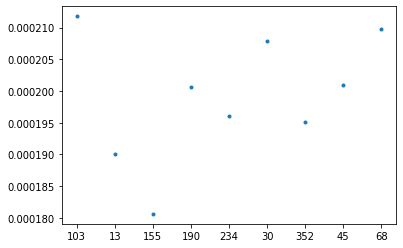

In [91]:
# gold and Si melt
import scipy.optimize
kappa_avg = []
for i, v in enumerate(list(Si_melting_W.keys())):
    popt, pcov = curve_fit(expo, power_used[v], dRoverR_1[i], p0 = [1, 0.00000000838, 1], maxfev = 10000)
    #a, b, c = popt
    plt.plot(power_used[v], dRoverR_1[i], '.')
    y_pred = [expo(j, *popt) for j in power_used[v]]
    plt.plot(power_used[v], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_Si&gold_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    
    
    fun = lambda k: (expo(Si_melting_W[v], *popt) - (1410-21)*k)**2 + (expo(gold_melting_W[v], *popt) - (1064-21)*k)**2
    res = scipy.optimize.minimize(fun, 0.00016)
    temp_pred = [expo(j, *popt)/res.x for j in power_used[v]]
    plt.plot(power_used[v], temp_pred)
    
    plt.plot(Si_melting_W[v], 1410, marker="o",color = 'r', label='Si')
    plt.plot(gold_melting_W[v], 1064, marker="o", color = 'g', label='gold')
    plt.legend(loc="upper left")
    plt.xlabel("power")
    plt.ylabel("temperature")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_gold_Si_fit/{}mm.png".format(v), format="PNG")
    plt.close()
    
#     f = expo(Si_melting_W[v], *popt)
#     gold_m = 1410
#     dT = gold_m - 21
#     kappa = f / dT
    kappa_avg.append(float(res.x))
    
Dict_kappa_avg = dict(zip(list(Si_melting_W.keys()),kappa_avg))

plt.plot(list(Si_melting_W.keys()), kappa_avg, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_kappa_gold&Si.png", format="PNG")

In [92]:
con = 0
for i, v in enumerate(Dict_kappa_avg.keys()):
    con = con + Dict_kappa_avg[v]
kappa_avg = con / len(Dict_kappa_avg)
kappa_avg

0.00019919975209590292

In [93]:
peak_temp = []
for i, v in enumerate(list(Si_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_avg[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(Si_melting_W.keys()),peak_temp))

## fit plane f(power, log10 velocity) = Tpeak 

### The one I sent to them

In [95]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 5.10348097e+02 -9.42988739e+01 -8.27359789e+02  9.36267138e+01
  1.68728213e+03  1.13004963e+00  2.35634551e-02  3.99151018e+00]
1077.414935858704


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_9385/507234216.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [59]:
# from sympy import solve
# from sympy.abc import y, x, z, a, b, c, d, e, f, g, h

# a, b, c, d, e, f, g, h=  5.30354554e+02, -9.60250760e+01, -7.98869136e+02 , 9.13980490e+01, 1.35226042e+03 , 1.11308546e+00 , 2.22079583e-02 , 3.88779414e+00

# solve(function([x,y], a, b, c, d, e, f, g, h) - z, x)



### converter

In [17]:
parameters_T = np.array([ 5.30354554e+02, -9.60250760e+01, -7.98869136e+02 , 9.13980490e+01,
  1.35226042e+03 , 1.11308546e+00 , 2.22079583e-02 , 3.88779414e+00])

def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_T
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])

In [18]:
get_power(88200/352, 1064)

46.311040925364225

# plot temperature vs power

In [96]:
import matplotlib.pyplot as plt
%matplotlib

for velocity in np.unique(y_data):
    mask = y_data == velocity
    plt.plot(x_data[mask], z_data[mask], label = str(round(np.exp(y_data[mask][0])))+'mm/s')
    plt.legend()

Using matplotlib backend: MacOSX


## fit plane f(Tpeak, log tau) = power (beamwidth needed) 要改

 ### don't use this, should just use inverse function...

In [21]:
beamwidth = 88200

import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[tau,T,P])]
    points.append(point)


x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # tau/dwell time
        y_data.append(item[1]) # T
        z_data.append(item[2]) # power
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = y_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters_3, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=100000)
print(parameters_3)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters_3)

z_predicted = function([x_data, y_data], *parameters_3)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('ln tau/dwell time', fontsize=30, labelpad=40)
axes.set_ylabel('Tpeak - Celsius',fontsize=30, labelpad=40)
axes.set_zlabel('Power - W', fontsize=30, labelpad=40)
axes.set_ylim(400, 1400)
#axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_4269/4149000367.py:32: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


[ 4.58541688e+00  8.27490988e-04 -4.54608962e+00  1.00031164e+00
 -1.93052376e+00  2.09456701e+01  2.79200239e+01]
1.9500024414102124


In [22]:
import numpy as np
from scipy.optimize import leastsq

parameters_3 = np.array([ 4.58541688e+00 , 8.27490988e-04, -4.54608962e+00,  1.00031164e+00,
 -1.93052376e+00 , 2.09456701e+01 , 2.79200239e+01])

def get_power_3(dwell, Tpeak):
    lntau = np.log(dwell)
    the_input = [lntau,Tpeak]
    a, b, c, d, e, f, g = parameters_3
    
    return function(the_input, a, b, c, d, e, f, g)

In [24]:
get_power_3(88200/352, 1064)

43.921212855997354

# Invertible function

In [88]:
# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y)*x**2.5 + (c+d*y) + e

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

[ 3.35953767e-01 -4.56819427e-02 -4.19905626e+06  4.48100862e+01
  4.19888221e+06]
1879.5946362863392


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_12673/690333852.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [90]:
from sympy import solve
from sympy.abc import y, x, z, a, b, c, d, e

a, b, c, d, e= 3.35953767e-01, -4.56819427e-02, -4.19905626e+06 , 4.48100862e+01, 4.19888221e+06
solve(function([x,y], a, b, c, d, e ) - z, x)


[246475.015135061*(-(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2 - 0.726542528005361*I*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2)**2,
 246475.015135061*(-(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2 + 0.726542528005361*I*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2)**2,
 340620.09353901*(0.324919696232906*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2 - I*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.005745

# lateral temperature profile

In [97]:
dRoverR_allpoints = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_dR_over_R(file, back_intensity_list_1[i])
        con.append(val)
    dRoverR_allpoints.append(con)
    
dRoverR_lines = []
for velo in dRoverR_allpoints:
    con_1 = []
    for R in velo:
        val = R[round((X_right_boundry-X_left_boundry)/2),:]
        con_1.append(val)
    dRoverR_lines.append(con_1)

temp_lines = []    
for i, v in enumerate(list(Dict_1.keys())):
    con_2 = []
    velo = dRoverR_lines[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_avg[v])
        con_2.append(temp)
    temp_lines.append(con_2)
    
parameters = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    velo = temp_lines[i]
    for t in velo:
        [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
        con.append([height, x_0, sigma1, sigma2])
    parameters.append(con)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# fit sigma1, sigma2 plane

In [98]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

beamwidth = 88200

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g


points_1 = []
points_2 = []

for i, v in enumerate(list(Si_melting_W.keys())):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    sigma1 = [el[2] for el in parameters[i]]
    sigma2 = [el[3] for el in parameters[i]]
    point1 = [list(x) for x in zip(*[P,tau,sigma1,T])]
    points_1.append(point1)
    point2 = [list(x) for x in zip(*[P,tau,sigma2,T])]
    points_2.append(point2)

    
x_data = []
y_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # tau
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[3]) # Tpeak
        

for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
        
        
x_data, y_data, z_data_1, z_data_2, t_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data)


mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]


parameters_1, covariance_1 = curve_fit(function, [x_data, y_data], z_data_1,  maxfev=1000000)
parameters_2, covariance_2 = curve_fit(function, [x_data, y_data], z_data_2,  maxfev=1000000)

print(parameters_1)
print(parameters_2)

model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z1 = function(np.array([X, Y]), *parameters_1)
Z2 = function(np.array([X, Y]), *parameters_2)

z_predicted_1 = function([x_data, y_data], *parameters_1)
z_predicted_2 = function([x_data, y_data], *parameters_2)

differences_1 = np.subtract(z_data_1, z_predicted_1)
differences_2 = np.subtract(z_data_2, z_predicted_2)

squared_differences_1 = np.square(differences_1)
squared_differences_2 = np.square(differences_2)

mse_1 = squared_differences_1.mean()
mse_2 = squared_differences_2.mean()
print(mse_1)
print(mse_2)

Using matplotlib backend: MacOSX
[-1.40145810e+04 -3.26969897e-03 -1.40113862e+04  5.01639131e-03
  1.54685580e+04 -1.46848957e+05 -1.95501057e+08]
[ 1.20642045e+02  2.67799592e-03  1.20558289e+02  1.01468670e+00
 -1.08645002e+01 -1.53372006e+04  2.05449540e+03]
3733394573.73632
42097.67573159603


In [99]:
f1 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes1 = Axes3D(f1)

axes1.plot_surface(X, Y, Z1, cmap=cm.hot, alpha=0.2)
axes1.scatter(x_data, y_data, z_data_1, s=500)

axes1.set_title('Scatter Plot')
axes1.set_xlabel('power - W', fontsize=30, labelpad=40)
axes1.set_ylabel('tau',fontsize=30, labelpad=40)
axes1.set_zlabel('sigma1', fontsize=30, labelpad=40)

axes1.tick_params(axis='both', which='major', labelsize=30)
 
plt.show()
print(mse_1)

3733394573.73632


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_9385/2512510063.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes1 = Axes3D(f1)


In [100]:
f2 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes2 = Axes3D(f2)

axes2.plot_surface(X, Y, Z2, cmap=cm.hot, alpha=0.2)
axes2.scatter(x_data, y_data, z_data_2, s=500)

axes2.set_title('Scatter Plot')
axes2.set_xlabel('power - W', fontsize=30, labelpad=40)
axes2.set_ylabel('tau',fontsize=30, labelpad=40)
axes2.set_zlabel('sigma2', fontsize=30, labelpad=40)

axes2.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse_2)

42097.67573159603


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_9385/3592995763.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes2 = Axes3D(f2)
